# Experiments

In [5]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import time
import networkx as nx
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
from torch_geometric.utils import from_networkx

from utils.prep_data import load_data, split_data, mask_data, Experiment
from utils.train import train
from utils.dataset import WindFarmDataset
from GCGRU.GRU import GRU
from GCGRU.GCGRU import GCGRU

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


### Preprocess data

#### Load the data

In [ ]:
data = load_data(columns=["TurbID", "Wspd", "Wdir", "Etmp", "Itmp", "Ndir", "Pab1", "Pab2", "Pab3", "Prtv", "Patv", "datetime"])
nan_mask = ~data["Patv"].isna().to_numpy()
# subset of turbines for faster experiments
turbines_idx = [9, 10, 11, 12, 31, 32, 33, 34, 35, 52, 53, 54, 55, 56, 57]
data = data[data["TurbID"].isin(turbines_idx)]

# dictionaries to map turbine ids to node ids and reverse
idx2turbine = {i: turb_id for i, turb_id in enumerate(turbines_idx)}
turbine2idx = {turb_id: i for i, turb_id in enumerate(turbines_idx)}

# normalize features
features = ["Wspd", "Wdir", "Etmp", "Itmp", "Ndir", "Pab1", "Pab2", "Pab3", "Prtv", "Patv"]
data[features] = data[features].apply(lambda col: ((col - col.min()) / (col.max() - col.min())))

train_data, val_data, test_data = split_data(data, splits=[0.7, 0.2, 0.1])

Split the nan masks

In [ ]:
train_nan_mask = nan_mask[train_data.index]
val_nan_mask = nan_mask[val_data.index]
test_nan_mask = nan_mask[test_data.index]

Reset data split indices

In [ ]:
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

Assign corresponding split means to actual nan values

In [ ]:
train_mean = train_data["P_norm"].mean()
train_data.loc[~train_nan_mask, "P_norm"] = train_mean

val_mean = val_data["P_norm"].mean()
val_data.loc[~val_nan_mask, "P_norm"] = val_mean

test_mean = test_data["P_norm"].mean()
test_data.loc[~test_nan_mask, "P_norm"] = test_mean

### RNN-based models

In [ ]:
def rnn_split_by_time(data: pd.DataFrame, nan_mask: np.ndarray, data_mask: np.ndarray, feature_cols: list, target_col: str):
    timestamps = data["datetime"].unique()
    timestamps = timestamps[timestamps.argsort()]

    xs = []
    ys = []
    nan_masks = []
    data_masks = []
    for i, curr_timestamp in enumerate(timestamps[:-1]):
        next_timestamp = timestamps[i+1]

        # sort to match with pytorch geometric node ids
        curr_df = data[data["datetime"] == curr_timestamp].sort_values("TurbID")
        next_df = data[data["datetime"] == next_timestamp].sort_values("TurbID")
        
        x = torch.tensor(curr_df[feature_cols].values)
        # simulate missing values on current data (normalized data, use 0.5)
        x[~data_mask[curr_df.index]] = 0.5
        xs.append(x)
        ys.append(torch.tensor(next_df[[target_col]].values))

        nan_masks.append(torch.tensor(nan_mask[next_df.index]))
        data_masks.append(torch.tensor(data_mask[next_df.index]))

    xs = torch.stack(xs).to(device)
    ys = torch.stack(ys).to(device)
    nan_masks = torch.stack(nan_masks).to(device)
    data_masks = torch.stack(data_masks).to(device)

    return xs, ys, nan_masks, data_masks

In [ ]:
def format_sliding_window(xs: torch.Tensor, ys: torch.Tensor, nan_masks: torch.Tensor, data_masks: torch.Tensor, t: int = 6 * 24):
    X_window, y_window, nan_masks_window, data_masks_window = [], [], [], []
    for i in range(xs.shape[0] - t):
        X_window.append(xs[i:(i+t)])
        y_window.append(ys[i:(i+t)])

        nan_masks_window.append(nan_masks[i:(i+t)])
        data_masks_window.append(data_masks[i:(i+t)])

    return torch.stack(X_window), torch.stack(y_window), torch.stack(nan_masks_window), torch.stack(data_masks_window)

#### GRU

Define function to create separate GRU models per turbine and run experiment.

In [ ]:
def GRU_experiment(experiments: dict, experiment: Experiment, size: float, feature_columns: list, target_column: str):
    print(f"Starting GRU experiment {experiment}, size={size}...")
    print("Loading experiment data...")
    data_start_time = time.time()
    train_xs, train_ys, train_nan_masks, train_data_masks = rnn_split_by_time(train_data, train_nan_mask, experiments[experiment]["train"][size], feature_cols=feature_columns, target_col=target_column)
    val_xs, val_ys, val_nan_masks, val_data_masks = rnn_split_by_time(val_data, val_nan_mask, experiments[experiment]["val"][size], feature_cols=feature_columns, target_col=target_column)
    test_xs, test_ys, test_nan_masks, test_data_masks = rnn_split_by_time(test_data, test_nan_mask, experiments[experiment]["test"][size], feature_cols=feature_columns, target_col=target_column)

    print(f"Data loading finished in {time.time() - data_start_time} seconds. Starting training...")
    models = {turb_id: GRU(len(feature_columns), 16, 1) for turb_id in data['TurbID'].unique()}

    lr = 0.01
    epochs = 100
    batch_size = 512
    turbine_train_losses, turbine_val_losses = {}, {}

    start_time = time.time()

    for turb_id, model in models.items():
        optimizer = torch.optim.Adam(list(model.parameters()), lr=lr)
        criterion = torch.nn.MSELoss()

        model.to(device)
        criterion.to(device)

        train_X, train_y, train_nm, train_dm = format_sliding_window(train_xs[:, turbine2idx[turb_id], :], train_ys[:, turbine2idx[turb_id], :], train_nan_masks[:, turbine2idx[turb_id]], train_data_masks[:, turbine2idx[turb_id]])
        train_loader = DataLoader(WindFarmDataset(train_X, train_y, train_nm, train_dm), batch_size=batch_size)

        val_X, val_y, val_nm, val_dm = format_sliding_window(val_xs[:, turbine2idx[turb_id], :], val_ys[:, turbine2idx[turb_id], :], val_nan_masks[:, turbine2idx[turb_id]], val_data_masks[:, turbine2idx[turb_id]])
        val_loader = DataLoader(WindFarmDataset(val_X, val_y, val_nm, val_dm), batch_size=batch_size)

        print(f"Training GRU for turbine {turb_id}")
        models[turb_id], train_losses, val_losses = train(model, train_loader, val_loader, optimizer, criterion, epochs=epochs, patience=10)
        print("\n----------------------------------------------------------\n")
        test_X, test_y, test_nm, test_dm = format_sliding_window(test_xs[:, turbine2idx[turb_id], :], test_ys[:, turbine2idx[turb_id], :], test_nan_masks[:, turbine2idx[turb_id]], test_data_masks[:, turbine2idx[turb_id]])
        with torch.no_grad():
            test_preds = models[turb_id](test_X)

            # Pure imputation task -> loss based on predicting simulated missing values correctly
            test_loss_mask = (test_nm == 1) & (test_dm == 0)
            test_loss = criterion(test_preds[test_loss_mask], test_y[test_loss_mask])
        print(f"Best model test loss: {test_loss.item():.4f}")
        print("\n\n")

        turbine_train_losses[turb_id] = train_losses
        turbine_val_losses[turb_id] = val_losses

    elapsed_time = time.time() - start_time
    print(f"Training took {elapsed_time:.3f} seconds")

    print("Saving losses and best model parameters...")
    for turb_id, model in models.items():
        torch.save(model.state_dict(), f"../data/experiment_results/{experiment}/{size}/GRU/turbine_{turb_id}_params.pth")
        with open(f"../data/experiment_results/{experiment}/{size}/GRU/train_losses.csv", "a") as f:
            line = f"{turb_id}," + ",".join(map(str, turbine_train_losses[turb_id])) + "\n"
            f.write(line)
        with open(f"../data/experiment_results/{experiment}/{size}/GRU/val_losses.csv", "a") as f:
            line = f"{turb_id}," + ",".join(map(str, turbine_val_losses[turb_id])) + "\n"
            f.write(line)


Training GRU for turbine 9
Epoch: 1;	training loss: 0.0214;	validation loss: 0.0091
Epoch: 10;	training loss: 0.0104;	validation loss: 0.0085
Stopping early on epoch 16



Training GRU for turbine 10
Epoch: 1;	training loss: 0.0680;	validation loss: 0.0100
Epoch: 10;	training loss: 0.0099;	validation loss: 0.0068
Epoch: 20;	training loss: 0.0095;	validation loss: 0.0063
Epoch: 30;	training loss: 0.0092;	validation loss: 0.0061
Epoch: 40;	training loss: 0.0090;	validation loss: 0.0061
Epoch: 50;	training loss: 0.0088;	validation loss: 0.0061
Epoch: 60;	training loss: 0.0087;	validation loss: 0.0060
Epoch: 70;	training loss: 0.0086;	validation loss: 0.0060
Epoch: 80;	training loss: 0.0084;	validation loss: 0.0060
Epoch: 90;	training loss: 0.0082;	validation loss: 0.0060
Stopping early on epoch 92



Training GRU for turbine 11
Epoch: 1;	training loss: 0.0457;	validation loss: 0.0147
Epoch: 10;	training loss: 0.0113;	validation loss: 0.0081
Stopping early on epoch 19



Training GRU for t

#### GCGRU

Load turbine locations to build graph

In [ ]:
turbines = pd.read_csv('../data/turbines.csv', index_col=False)
turbines = turbines[turbines['TurbID'].isin(turbines_idx)]
turbines.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 8 to 56
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TurbID  15 non-null     int64  
 1   x       15 non-null     float64
 2   y       15 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 480.0 bytes


In [ ]:
x_min = turbines['x'].min()
x_max = turbines['x'].max()
y_min = turbines['y'].min()
y_max = turbines['y'].max()
turbines['x'] = (turbines['x'] - x_min) / (x_max - x_min)
turbines['y'] = (turbines['y'] - y_min) / (y_max - y_min)

In [ ]:
pos_dict = {row["TurbID"].astype(int): (row["x"], row["y"]) for _, row in turbines.iterrows()}

In [ ]:
radius = 1500
radius_x = radius / (x_max - x_min)
radius_y = radius / (y_max - y_min)

In [ ]:
G = nx.Graph()
turbines.apply(lambda x: G.add_node(int(x.TurbID), pos=(x.x, x.y)), axis=1)
G.nodes

NodeView((9, 10, 11, 12, 31, 32, 33, 34, 35, 52, 53, 54, 55, 56, 57))

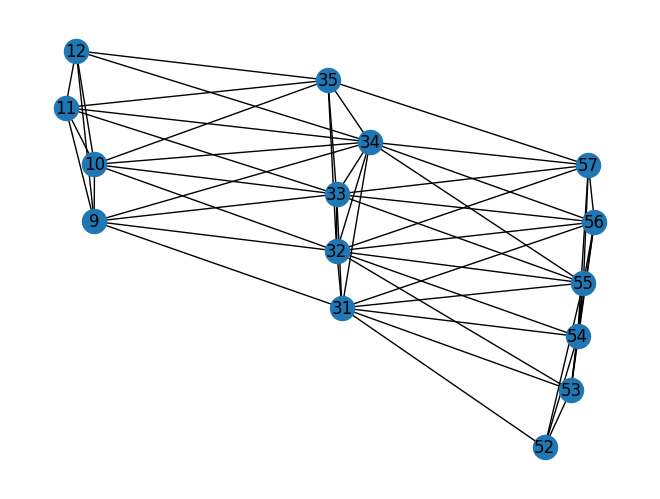

In [ ]:
def construct_graph(turbine1, turbine2, radius_x, radius_y):
    n1 = int(turbine1.TurbID)
    n2 = int(turbine2.TurbID)
    if n1 < n2:
        distance = np.sqrt(((turbine2.x - turbine1.x) / radius_x)**2 + ((turbine2.y - turbine1.y) / radius_y)**2)
        if distance <= 1:
            G.add_edge(n1, n2)
turbines.apply(lambda x: turbines.apply(lambda y: construct_graph(x,y,radius_x, radius_y), axis=1),axis=1)
nx.draw(G, pos=pos_dict, labels={t: t for t in turbines_idx})

Define function to create the model and perform the experiment

In [ ]:
def GCGRU_experiment(experiments: dict, experiment: Experiment, size: float, feature_columns: list, target_column: str):
    print(f"Starting GCGRU experiment {experiment}, size={size}...")
    print("Loading experiment data...")
    data_start_time = time.time()
    train_xs, train_ys, train_nan_masks, train_data_masks = rnn_split_by_time(train_data, train_nan_mask, experiments[experiment]["train"][size], feature_cols=feature_columns, target_col=target_column)
    val_xs, val_ys, val_nan_masks, val_data_masks = rnn_split_by_time(val_data, val_nan_mask, experiments[experiment]["val"][size], feature_cols=feature_columns, target_col=target_column)
    test_xs, test_ys, test_nan_masks, test_data_masks = rnn_split_by_time(test_data, test_nan_mask, experiments[experiment]["test"][size], feature_cols=feature_columns, target_col=target_column)

    print(f"Data loading finished in {time.time() - data_start_time} seconds. Starting training...")
    model = GCGRU(in_dim=len(feature_columns), hid_dim=16, out_dim=1, edge_index=from_networkx(G).edge_index)

    lr = 0.01
    epochs = 100
    batch_size = 512
    optimizer = torch.optim.Adam(list(model.parameters()), lr=lr)
    criterion = torch.nn.MSELoss()

    model.to(device)
    criterion.to(device)

    start_time = time.time()

    train_X, train_y, train_nm, train_dm = format_sliding_window(train_xs, train_ys, train_nan_masks, train_data_masks)
    train_loader = DataLoader(WindFarmDataset(train_X, train_y, train_nm, train_dm), batch_size=batch_size)

    val_X, val_y, val_nm, val_dm = format_sliding_window(val_xs, val_ys, val_nan_masks, val_data_masks)
    val_loader = DataLoader(WindFarmDataset(val_X, val_y, val_nm, val_dm), batch_size=batch_size)

    print(f"Training GCGRU: ")
    model, train_losses, val_losses = train(model, train_loader, val_loader, optimizer, criterion, epochs=epochs, patience=10)
    print("\n----------------------------------------------------------\n")
    test_X, test_y, test_nm, test_dm = format_sliding_window(test_xs, test_ys, test_nan_masks, test_data_masks)
    with torch.no_grad():
        test_preds = model(test_X)

        # Pure imputation task -> loss based on predicting simulated missing values correctly
        test_loss_mask = (test_nm == 1) & (test_dm == 0)
        test_loss = criterion(test_preds[test_loss_mask], test_y[test_loss_mask])
    print(f"Best model test loss: {test_loss.item():.4f}")
    print("\n\n")

    elapsed_time = time.time() - start_time
    print(f"Training took {elapsed_time:.3f} seconds")

    print("Saving losses and best model parameters...")
    torch.save(model.state_dict(), f"../data/experiment_results/{experiment}/{size}/GCGRU/params.pth")
    with open(f"../data/experiment_results/{experiment}/{size}/GCGRU/train_losses.csv", "w") as f:
        line = ",".join(map(str, train_losses))
        f.write(line)
    with open(f"../data/experiment_results/{experiment}/{size}/GCGRU/val_losses.csv", "w") as f:
        line = ",".join(map(str, val_losses))
        f.write(line)

Training GCGRU: 
Epoch: 1;	training loss: 0.0170;	validation loss: 0.0083
Epoch: 10;	training loss: 0.0111;	validation loss: 0.0076
Epoch: 20;	training loss: 0.0107;	validation loss: 0.0070
Epoch: 30;	training loss: 0.0104;	validation loss: 0.0068
Epoch: 40;	training loss: 0.0099;	validation loss: 0.0066
Epoch: 50;	training loss: 0.0096;	validation loss: 0.0066
Stopping early on epoch 54



Training took 23957.862 seconds


## Experiments

### Experiment setup

Create masks for different splits

In [ ]:
random_percentages = [0.01, 0.02, 0.05, 0.1]
blackout_periods = [30, 60, 150, 300]
maintenance_periods = [1, 2, 7, 14]

In [ ]:
train_masks_random = { size: mask_data(train_data, base_mask=None, experiment=Experiment.RANDOM, size = size) for size in random_percentages }
val_masks_random = { size: mask_data(val_data, base_mask=None, experiment=Experiment.RANDOM, size = size) for size in random_percentages }
test_masks_random = { size: mask_data(test_data, base_mask=None, experiment=Experiment.RANDOM, size = size) for size in random_percentages }

In [ ]:
train_masks_blackout = { size: mask_data(train_data, base_mask=None, experiment=Experiment.BLACKOUT, size=size) for size in blackout_periods }
val_masks_blackout = { size: mask_data(val_data, base_mask=None, experiment=Experiment.BLACKOUT, size=size) for size in blackout_periods }
test_masks_blackout = { size: mask_data(test_data, base_mask=None, experiment=Experiment.BLACKOUT, size=size) for size in blackout_periods }

In [ ]:
train_masks_maintenance = { size: mask_data(train_data, base_mask=None, experiment=Experiment.MAINTENANCE, size=size) for size in maintenance_periods }
val_masks_maintenance = { size: mask_data(val_data, base_mask=None, experiment=Experiment.MAINTENANCE, size=size) for size in maintenance_periods }
test_masks_maintenance = { size: mask_data(test_data, base_mask=None, experiment=Experiment.MAINTENANCE, size=size) for size in maintenance_periods }

In [ ]:
experiments = {
    Experiment.RANDOM: {
        "train": train_masks_random,
        "val": val_masks_random,
        "test": test_masks_random,
    },
    Experiment.BLACKOUT: {
        "train": train_masks_blackout,
        "val": val_masks_blackout,
        "test": test_masks_blackout,
    },
    Experiment.MAINTENANCE: {
        "train": train_masks_maintenance,
        "val": val_masks_maintenance,
        "test": test_masks_maintenance,
    }
}

Define feature / target columns to use

In [ ]:
feature_columns = ["Wspd", "Wdir", "Etmp", "Itmp", "Ndir", "Pab1", "Pab2", "Pab3", "Prtv", "Patv"]  # features should be normalized during preprocess
target_column = "Patv"  # P_norm not used, since all features should be normalized

### Run experiments

Run all experiments for GRU

In [ ]:
for size in random_percentages:
    GRU_experiment(experiments, Experiment.RANDOM, size, feature_columns, target_column)

In [ ]:
for size in blackout_periods:
    GRU_experiment(experiments, Experiment.BLACKOUT, size, feature_columns, target_column)

In [ ]:
for size in maintenance_periods:
    GRU_experiment(experiments, Experiment.MAINTENANCE, size, feature_columns, target_column)

Run all experiments for GCGRU

In [ ]:
for size in random_percentages:
    GCGRU_experiment(experiments, Experiment.RANDOM, size, feature_columns, target_column)

In [ ]:
for size in blackout_periods:
    GCGRU_experiment(experiments, Experiment.BLACKOUT, size, feature_columns, target_column)

In [ ]:
for size in maintenance_periods:
    GCGRU_experiment(experiments, Experiment.MAINTENANCE, size, feature_columns, target_column)